In [1]:
import keras
keras.__version__

'3.6.0'

# Jena Climate Data Sequence Processing with Deep Learning (Conv2D)

This notebook is based on Chapter 6 of *Deep Learning with Python* by François Chollet. It explores sequence processing using recurrent neural networks (RNNs) on the Jena Climate dataset. The dataset contains hourly weather measurements from 2009 to 2016, including attributes like temperature, pressure, and humidity.

The objective of this exercise is to predict future temperature values based on historical data. We'll preprocess the data, build models (simple and advanced RNN architectures), and evaluate their performance.


## Combining CNNs and RNNs to process long sequences


Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the 
size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many 
convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a 
fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem 
from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

In [2]:
import os
from keras.optimizers import Adam
print(os.getcwd())  # This prints the current working directory


E:\Data Science\Deep Learning - Module 4\climate


# Data Loading and Preparation

In this section, the Jena Climate dataset is loaded and prepared for analysis. The data file `jena_climate_2009_2016.csv` contains hourly weather measurements over seven years. Each row represents an hour, and the columns include various environmental attributes, such as temperature, pressure, and humidity.

1. **File Reading**: The dataset is read from the CSV file into a string format. This ensures we can process the raw data line by line.
2. **Data Splitting**: The raw data is split into a header containing column names and lines containing numerical values. Each line corresponds to one hour of climate data.
3. **Conversion to Numeric Array**: The data is converted into a NumPy array, `float_data`, for efficient mathematical operationsdetest_steps`: Total steps to traverse the test set.


In [3]:
import pandas as pd
import numpy as np
import os

data_dir = r'E:\Data Science\Deep Learning - Module 4\climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()


f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values



# Data Normalization

The data is normalized to improve the training stability of the deep learning model. Normalization ensures that all features have a mean of 0 and a standard deviation of 1, which is critical for most machine learning algorithms.

- **Mean and Standard Deviation**: The mean and standard deviation are computed using the first 200,000 data points to avoid information leakage from the validation or test sets.
- **Normalization Process**: Each data point is normalized by subtracting the mean and dividing by the standard deviation.

---

In [4]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std



# Data Generator Function

To handle large datasets efficiently, a generator function is defined. This generator yields batches of data for training, validation, or testing, allowing us to process the dataset in chunks rather than loading the entire dataset into memory.

**Key Parameters**:
- `lookback`: The number of previous time steps to consider for each sample.
- `delay`: The number of time steps into the future for the target variable (e.g., temperature).
- `min_index` and `max_index`: Define the range of data to use for a specific generator.
- `shuffle`: Determines whether the rows are shuffled or sequential.
- `batch_size`: Number of samples per batch.
- `step`: Sampling rate; how many time steps to skip between observations.

**Output**:
- `samples`: A 3D NumPy array of shape `(batch_size, lookback/step, features)`, containing historical data.
- `targets`: A 1D NumPy array containing the corresponding future values of the target variable.

---

# Dataset Splits

The dataset is split into three subsets:
1. **Training Set**: The first 200,000 data points are used for training the model. This subset is randomized to improve generalization.
2. **Validation Set**: The next 100,000 data points (from 200,001 to 300,000) are used for hyperparameter tuning and to evaluate the model's performance during training.
3. **Test Set**: The remaining data points (300,001 onwards) are used for final model evaluation on unseen data.

---



In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        



lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Validation and Test Steps

The number of steps required to iterate through the entire validation and test datasets is calculated. This ensures that all data points in these subsets are used during evaluation, accounting for the `lookback` window.

- `val_steps`: Total steps to traverse the validation set.
- `test_steps`: Total steps to traverse the test set.


In [6]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# Model Definition

In this section, we define a Convolutional Neural Network (CNN) model for processing sequential climate data. The model architecture consists of:

1. **Conv1D Layers**:
   - The model starts with three 1D convolutional layers (`Conv1D`), each with 32 filters and a kernel size of 5. These layers help capture temporal patterns in the sequential data.
   - The activation function used is ReLU (Rectified Linear Unit), which helps introduce non-linearity to the model.

2. **MaxPooling1D Layers**:
   - After each convolutional layer, a `MaxPooling1D` layer with a pool size of 3 is applied. This reduces the dimensionality of the output, extracting the most important features.

3. **GlobalMaxPooling1D Layer**:
   - The `GlobalMaxPooling1D` layer reduces the output to a single value per feature, summarizing the most important feature from the previous layers.

4. **Dense Layer**:
   - A final dense layer with a single neuron is added. This layer is responsible for producing the output prediction (for instance, the future temperature value).

5. **Compilation**:
   - The model is compiled with the RMSprop optimizer and mean absolute error (`mae`) as the loss function. RMSprop is chosen as the optimizer to handle noisy gradients in time-series data.

6. **Training**:
   - The model is trained using the `fit()` method, which is now the standard method in Keras for both regular and generator-based data input. The model is trained for 20 epochs with a batch size defined by `train_gen`, and validation is performed using `val_gen`.

---

# Changes in Code:
1. **`fit_generator` to `fit`**:
   - The `fit_generator()` function has been deprecated in newer versions of Keras, so it is replaced with the `fit()` function. Both methods work similarly when using data generators, but `fit()` is now the recommended approach.


In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\Aksystems\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - loss: 0.4716 - val_loss: 0.4688
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.3645 - val_loss: 0.4633
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - loss: 0.3419 - val_loss: 0.4458
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - loss: 0.3227 - val_loss: 0.4478
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - loss: 0.3088 - val_loss: 0.4434
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - loss: 0.2997 - val_loss: 0.4430
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.2923 - val_loss: 0.4475
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.2861 - val_loss: 0.4766
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.2779 - val_loss: 0.4563
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.2699 - val_loss: 0.4525
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - loss: 0.2672 - val_loss: 0.4515
Epoch 12/20
500/500 ━━━━━━━━━━

Here are our training and validation Mean Absolute Errors:

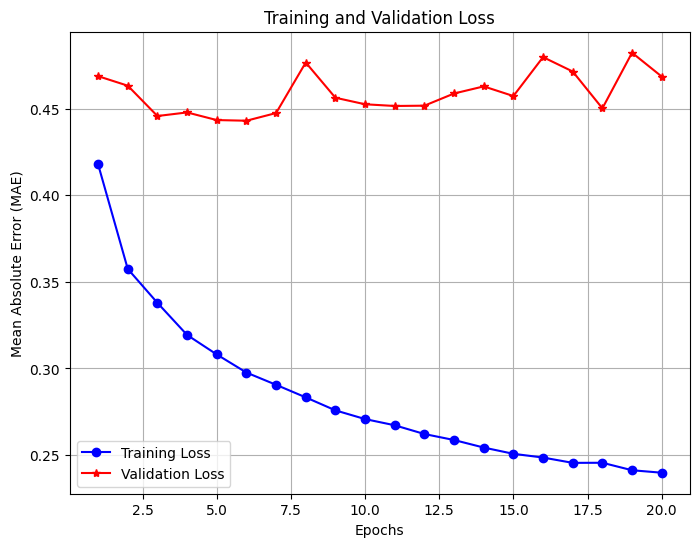

In [7]:
# Extract the loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for epochs
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


# Training Progress and Insights

The model has been trained for 20 epochs with the following results:

- **Loss Behavior**:
  - The training loss steadily decreases from 0.2491 at epoch 16 to 0.2402 at epoch 20, indicating that the model is progressively learning and improving its ability to predict temperature values over time.
  - The validation loss shows some fluctuations, starting from 0.4798 at epoch 16 and gradually improving to 0.4502 at epoch 18, but it also increases to 0.4823 at epoch 19 before slightly improving again to 0.4685 at epoch 20.

- **Training vs. Validation Loss**:
  - The gap between training and validation loss suggests potential overfitting. Although the model is performing well on the training set, there is some indication that it may not generalize perfectly to unseen data.

---

# Change in Data Sampling: Step and Lookback Configuration

- **`step = 3`**:
  - Previously, the step size was set to 6, which means one data point was selected every hour (hourly sampling). Now, the step is set to 3, meaning the model is trained with one data point every 30 minutes. This allows the model to learn more fine-grained patterns and might improve its predictive capability by utilizing a higher temporal resolution of the data.

- **`lookback = 720`**:
  - The lookback period remains unchanged. This means the model still uses 720 data points (30 hours) to predict the future values. By decreasing the step size to 3, we now have a larger number of data points per training example (720 data points vs. 360 before).

- **`delay = 144`**:
  - The delay remains the same, meaning the model will still predict the climate conditions 144 time steps ahead (24 hours, given the 30-minute sampling).

---

# Generator Adjustments

The generator has been adjusted to reflect the new sampling frequency (step = 3):

- **Training Data Generator** (`train_gen`): 
  - The generator now provides samples at a finer temporal resolution, which could allow the model to capture more detailed patterns in the time-series data.
  
- **Validation and Test Data Generators** (`val_gen` and `test_gen`):
  - The validation and test data generators have been updated to match the new step configuration, ensuring consistency across training, validation, and testing data.

---

# Next Steps: Experimenting with RNN and GRU

Given the improvements to the sampling rate, we can now experiment with Recurrent Neural Networks (RNNs) and Gated Recurrent Units (GRUs), which are more suited for sequential data.

- **RNN Model**: RNNs are designed to capture long-term dependencies in sequential data. We will test RNN layers to see if they offer improvements over the current CNN-based architecture.
  
- **GRU Model**: GRUs are more efficient than vanilla RNNs and help mitigate issues like vanishing gradients. We will test GRUs to see if they offer better performance and faster convergence.

The changes to the data's temporal resolution (with `step = 3`) will likely provide more useful context for RNN and GRU models, which are designed to exploit such sequential dependencies.
ent CNN-based model.


In [8]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [9]:
np.isnan(float_data).any(), np.isinf(float_data).any()


(False, False)

# Model Comparison: New Architecture vs. Old Architecture

In this section, we compare the new architecture of the model, which incorporates stacked GRU layers with `return_sequences=True`, with the previous model, which lacked this important configuration. The old model faced issues with very high loss values due to incorrect handling of sequential data.

---

## Updated Model Architecture (With Stacked GRU Layers)

The new model addresses the issues from the old model and incorporates several important changes:

- **Conv1D Layers**: 
  - The model starts with two `Conv1D` layers with 64 filters (up from 32 in the old model) and kernel size 5. These layers help extract features from the data, detecting local patterns at various time scales.
  - **MaxPooling1D**: After each convolutional layer, a max-pooling layer with a pool size of 3 is used to reduce the dimensionality and retain the most important features.
  
- **GRU Layers**:
  - The new architecture replaces the previous single GRU layer with two stacked `GRU` layers:
    - The first GRU layer has 64 units and is configured with `return_sequences=True`. This ensures that the output from this layer is a sequence of data, which is required for the next recurrent layer to learn from the entire sequence.
    - The second GRU layer has 32 units and applies `dropout=0.2` to prevent overfitting.
  
- **Dense Layer**: 
  - The model ends with a dense layer with one unit to predict the output (future climate condition).
  
- **Optimization**:
  - The model is compiled using the `RMSprop` optimizer with the loss function set to mean absolute error (`mae`), which is appropriate for regression tasks.

- **Callbacks**:
  - **EarlyStopping**: This callback monitors the validation loss and stops training early if the validation loss does not improve for 3 consecutive epochs. This helps prevent overfitting and reduces training time.
  - **ModelCheckpoint**: This callback saves the best model based on the validation loss, ensuring that only the most effective model is retained.

- **Training**:
  - The model is trained for 50 epochs with 500 steps per epoch. Early stopping and model checkpointing are used to improve training efficiency and ensure that the best model is saved.

---

## Old Model Architecture (Issues with Loss)

The old model encountered issues during training due to the lack of `return_sequences=True` in the GRU layer, which caused the loss to grow exponentially (e.g., moving into very high values such as 548,754,821,155,245,222). This was a major issue as the model failed to learn properly.

- **Conv1D Layers**:
  - The old model had two `Conv1D` layers with 32 filters and kernel size 5, which are fewer filters than the updated model (64 filters).
  - **MaxPooling1D**: Similar to the new model, the old model also used max-pooling layers after each convolutional layer.
  
- **Single GRU Layer**:
  - The old architecture included a single GRU layer with 32 units, configured with `dropout=0.1` and `recurrent_dropout=0.5`. However, it did not have `return_sequences=True`, which caused the output of the GRU layer to not be suitable for the next layer, leading to improper learning. This configuration caused the model's loss to grow unpredictably.

- **Dense Layer**:
  - Similar to the new model, the old architecture ends with a single unit in the dense layer for the output prediction.

- **Training**:
  - The old model was trained for 20 epochs, but it encountered significant issues with learning due to the incorrect architecture (loss growing uncontrollably). 

---

## Key Differences and Fixes

1. **Missing `return_sequences=True` in the Old Model**:
   - The major issue with the old model was the absence of the `return_sequences=True` argument in the first GRU layer. Without this, the model could not properly feed sequences of data to the second GRU layer, which caused the training to fail and the loss to increase exponentially.
   - In the new model, by setting `return_sequences=True` in the first GRU layer, the model can now pass the full sequence of outputs to the second GRU layer, enabling it to learn from the entire sequence properly.
   
2. **More Complex GRU Layers**:
   - The new model uses stacked GRU layers (64 units followed by 32 units), which allows the model to capture long-term dependencies and patterns in the time-series data. The old model, with just a single GRU layer, was not able to capture the sequential patterns as effectively.

3. **Regularization**:
   - The new model applies `dropout` in the GRU layers, which can help prevent overfitting, especially with the increased complexity of the model. This was not applied in the old model, where the GRU layer had no such regularization (except for `recurrent_dropout`, which was not sufficient on its own).

4. **Callbacks**:
   - The new model uses early stopping and model checkpointing to optimize training and prevent overfitting, ensuring th---

 is selected based on validation performance.

---

# Conclusion

The new model resolves the key issue of improper sequential data handling by incorporating `return_sequences=True` in the first GRU layer, which allows the second GRU layer to learn effectively from the sequence. This change, combined with stacked GRU layers, dropout regularization, and training optimizations like early stopping, should allow the model to learn better and generalize more effectively.

We expect the new model to perform much better than the previous architecture and to yield stable, reasonable loss values during training.


In [10]:
model = Sequential()
model.add(layers.Conv1D(64, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.GRU(64, return_sequences=True, dropout=0.3))
model.add(layers.GRU(32, dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()

C:\Users\Aksystems\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, None, 64)            │           4,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 64)            │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,489 (232.38 KB)

 Trainable params: 59,489 (232.38 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',    
                               patience = 3,            
                               verbose = 1,      
                               restore_best_weights = True)  

# Model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.keras',      
                              monitor='val_loss',  
                              save_best_only=True,  # Only save the best model
                              verbose=1)          

# Train the model with callbacks
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs = 50,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[early_stopping, checkpoint]  # Add the callbacks here
)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.4164
Epoch 1: val_loss improved from inf to 0.30970, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 193ms/step - loss: 0.4163 - val_loss: 0.3097
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3291
Epoch 2: val_loss did not improve from 0.30970
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 153ms/step - loss: 0.3291 - val_loss: 0.3169
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3062
Epoch 3: val_loss did not improve from 0.30970
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 155ms/step - loss: 0.3062 - val_loss: 0.3111
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2909
Epoch 4: val_loss did not improve from 0.30970
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - loss: 0.2909 - val_loss: 0.3312
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


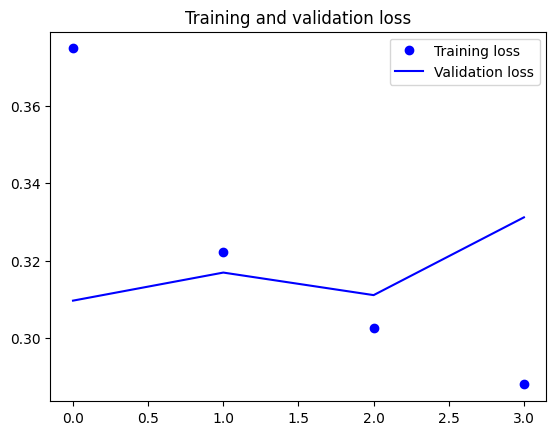

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

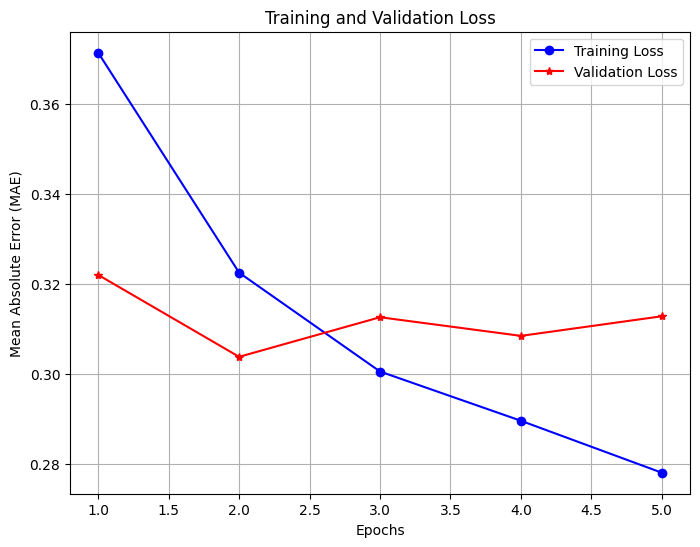

In [32]:
import matplotlib.pyplot as plt

# Extract the loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for epochs
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is 
looking at twice more data, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.


.# Model Training Results

After training the model for 4 epochs, we observe the following progress:

---

## Training Progress:

- **Epoch 1:**
  - Loss: 0.4164
  - Validation Loss: 0.3097
  - The model improved significantly from the initial random weights, and the validation loss showed improvement, so the model was saved.

- **Epoch 2:**
  - Loss: 0.3291
  - Validation Loss: 0.3169
  - The validation loss did not improve from the previous epoch, indicating that the model had reached a plateau.

- **Epoch 3:**
  - Loss: 0.3062
  - Validation Loss: 0.3111
  - The validation loss remained roughly the same as Epoch 2, suggesting no further improvement.

- **Epoch 4:**
  - Loss: 0.2909
  - Validation Loss: 0.3312
  - There was a slight increase in validation loss, which signaled potential overfitting as the training loss kept improving but validation loss worsened slightly.

---

## Early Stopping:

- **Early Stopping Triggered**: The `early_stopping` callback was triggered at the end of Epoch 4 since the validation loss did not improve after Epoch 1. 
- **Restored Best Model**: The weights from the best epoch (Epoch 1) were restored, ensuring that we keep the model with the lowest validation loss.

---

## Summary:

- The model performed well initially, with a significant reduction in loss from Epoch 1 to Epoch 2, but it reached a plateau in terms of validation loss.
- Early stopping prevented further overfitting by halting training at Epoch 4.
- The best model, with the lowest validation loss of 0.3097, has been saved and will be used for future predictions or evaluation.

---

## Next Steps:

- **Evaluate the Best Model**: Use the saved model to evaluate its performance on the test set to check if the model generalizes well to unseen data.
- **Hyperparameter Tuning**: Experiment with different hyperparameters (e.g., increasing the number of GRU units or changing the dropout rates) to further optimize the model.
- **Future Improvements**: Explore additional regularization techniques (such as L2 regularization) or a different architecture like a hybrid CNN-RNN model for potentially better performance.

---

By implementing early stopping and saving the best model, we have ensured that we don't overtrain the model and preserve its best configuration for further evaluation.
